In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from PIL import Image
import tensorflow as tf
import shutil
import os
import math
import time

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Concatenate,BatchNormalization, Dropout,Conv2D,MaxPooling2D, Activation
from keras import regularizers
from keras.models import Model,Sequential
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adadelta
from keras.utils import np_utils
from spp.SpatialPyramidPooling import SpatialPyramidPooling
from keras.utils.np_utils import to_categorical


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.visible_device_list = "0,1,2,3"
set_session(tf.Session(config=config))

ModuleNotFoundError: No module named 'tensorflow'

### Display Images

In [2]:
os.getcwd()

'/home/q433000/Hackathon'

In [3]:
path_to_images = '/home/q433000/data/Hackathon-BMW Images/model_X5'

list_of_X5_image_filepaths = glob.glob(path_to_images+'/*/*/*/*/*.jpg')

In [4]:
len(list_of_X5_image_filepaths)

3932

#### First 20 X5 Images

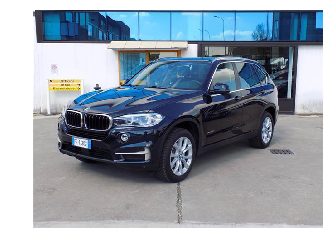

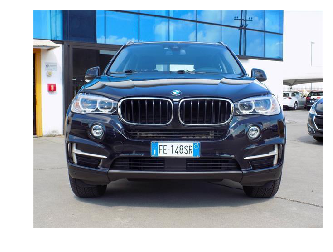

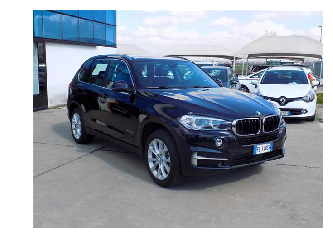

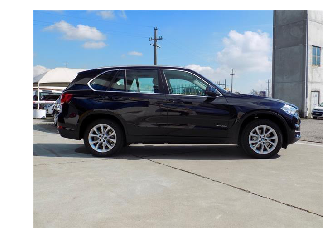

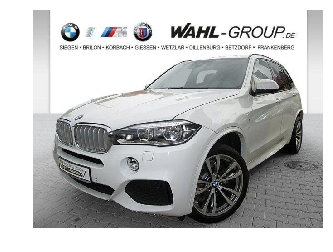

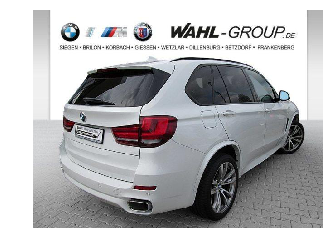

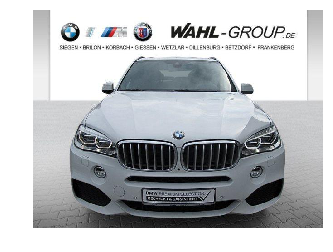

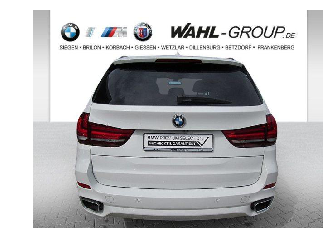

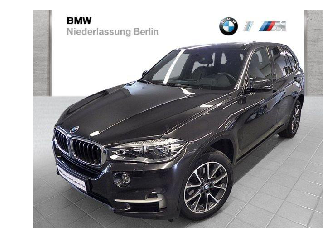

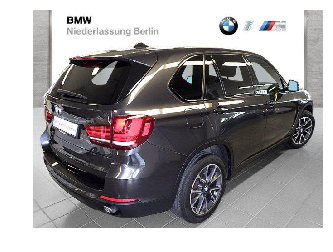

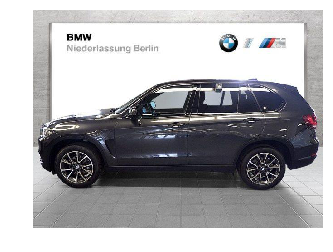

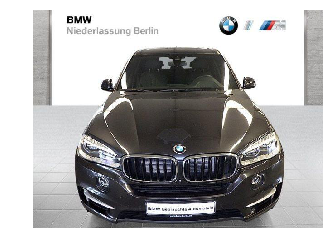

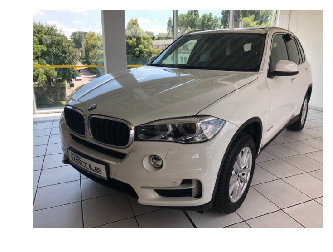

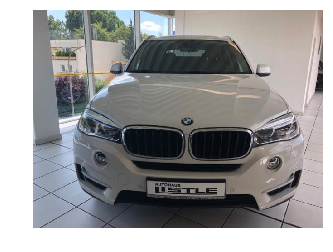

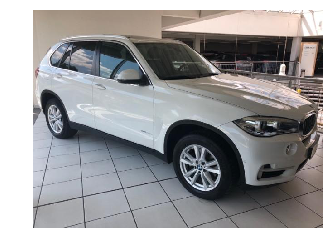

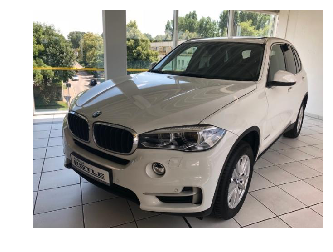

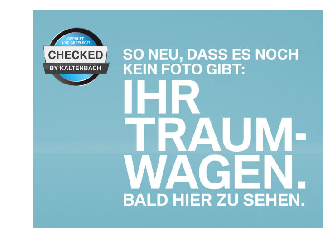

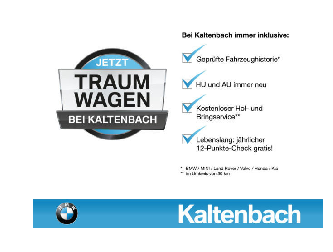

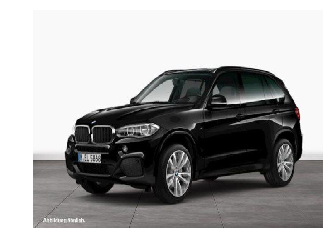

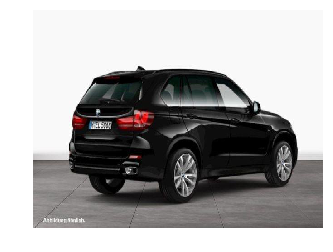

In [5]:
img_paths = list_of_X5_image_filepaths[:20]
for img_path in img_paths:
    img=load_img(img_path,target_size=(480, 640))
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

#### First 20 1er Images

In [5]:
path_to_images_1 = '/home/q433000/data/Hackathon-BMW Images/model_1er (alle)'
list_of_image_1_series_filepaths = glob.glob(path_to_images_1+'/*/*/*/*/*.jpg')
len(list_of_image_1_series_filepaths)

4287

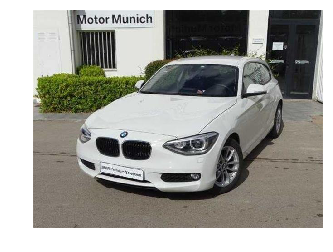

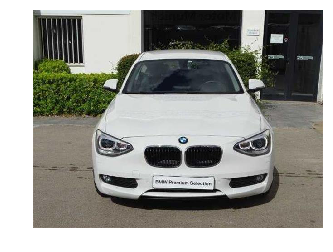

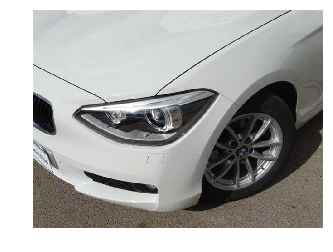

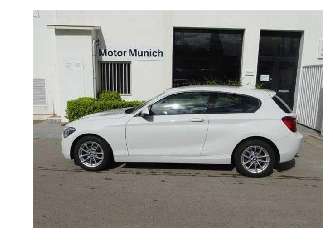

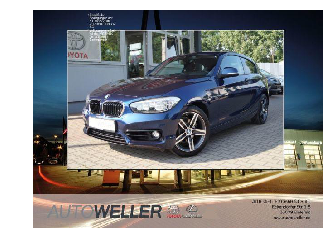

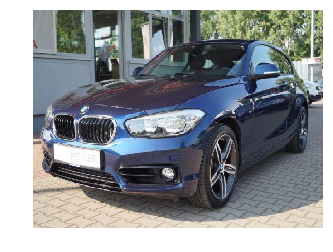

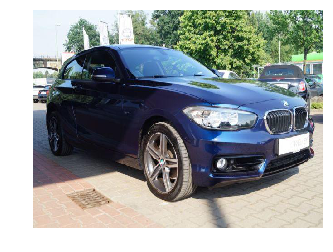

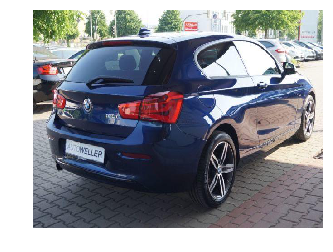

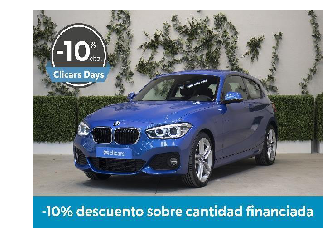

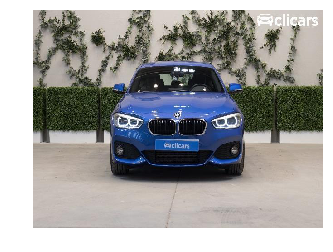

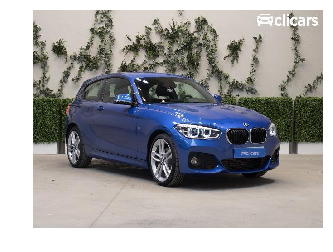

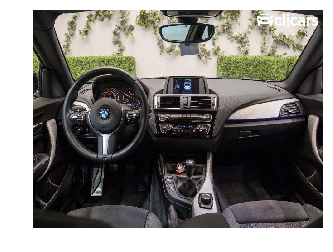

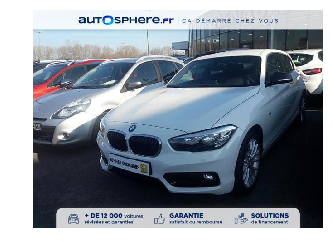

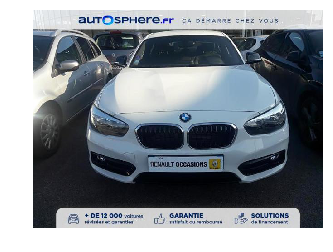

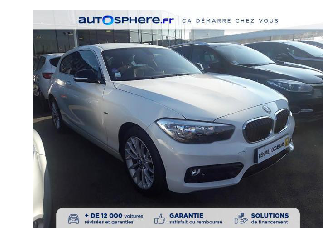

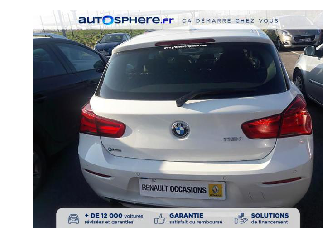

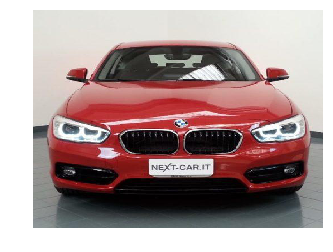

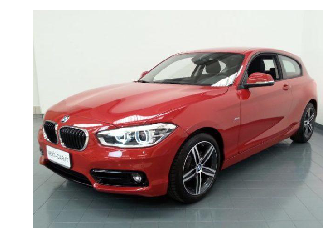

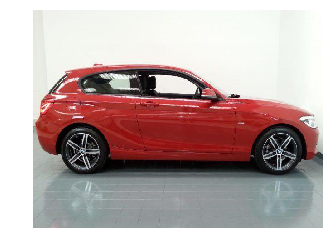

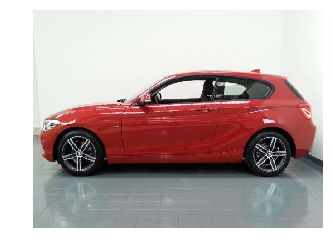

In [7]:
img_paths = list_of_image_1_series_filepaths[:20]
for img_path in img_paths:
    img=load_img(img_path,target_size=(480, 640))
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

### Train, Test, Validation Split

1. Quite Balanced Dataset ~4000:4000
2. Some Bad Images

Initial Split: ~ 6/8 = 3000 Train, 1/8 = 500 Test, 1/8 = 500 Validation

__Load Training Data__

In [8]:
X_train=[]
Y_train=[]

# Load 1 series train data
for img_path_1er in list_of_image_1_series_filepaths[:3000]:
    #load img + convert to numpy array
    img = np.asarray(load_img(img_path_1er,target_size=(480, 640)))
    X_train.append(img)
    
    #load label. 1 Series = 1
    Y_train.append(1)

# Load X5 train data
for img_path_X5 in list_of_X5_image_filepaths[:3000]:
    #load img
    img = np.asarray(load_img(img_path_X5,target_size=(480, 640)))
    X_train.append(img)
    
    #load label. X5 = 0
    Y_train.append(0)

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
        
print('training data loaded')
print(len(X_train),len(Y_train),X_train.shape,Y_train.shape)

training data loaded
6000 6000 (6000, 480, 640, 3) (6000,)


In [21]:
Y_train = to_categorical(Y_train)

In [25]:
Y_train.shape

(6000, 2)

__Load Test Data__

In [9]:
X_test=[]
Y_test=[]

# Load 1 series train data
for img_path_1er in list_of_image_1_series_filepaths[3000:3500]:
    #load img
    img = np.asarray(load_img(img_path_1er,target_size=(480, 640)))
    X_test.append(img)
    
    #load label. 1 Series = 1
    Y_test.append(1)

# Load X5 train data
for img_path_X5 in list_of_X5_image_filepaths[3000:3500]:
    #load img
    img = np.asarray(load_img(img_path_X5,target_size=(480, 640)))
    X_test.append(img)
    
    #load label. X5 = 0
    Y_test.append(0)

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
        
print('test data loaded')
print(len(X_test),len(Y_test),X_test.shape,Y_test.shape)

test data loaded
1000 1000 (1000, 480, 640, 3) (1000,)


In [20]:
Y_test = to_categorical(Y_test)

__Load Validation Data__

In [10]:
X_validation=[]
Y_validation=[]

# Load 1 series train data
for img_path_1er in list_of_image_1_series_filepaths[3500:]:
    #load img
    img = np.asarray(load_img(img_path_1er,target_size=(480, 640)))
    X_validation.append(img)
    
    #load label. 1 Series = 1
    Y_validation.append(1)

# Load X5 train data
for img_path_X5 in list_of_X5_image_filepaths[3500:]:
    #load img
    img = np.asarray(load_img(img_path_X5,target_size=(480, 640)))
    X_validation.append(img)

    #load label. X5 = 0
    Y_validation.append(0)

X_validation = np.asarray(X_validation)
Y_validation = np.asarray(Y_validation)
        
print('validation data loaded')
print(len(X_validation),len(Y_validation),X_validation.shape,Y_validation.shape)

validation data loaded
1219 1219 (1219, 480, 640, 3) (1219,)


In [22]:
Y_validation = to_categorical(Y_validation)

### Implement Deep Learning Model

In [11]:
def load_simple_model(input_shape):
    model = Sequential()
    #conv block 1
    model.add(Conv2D(32,(3,3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #conv block2
    model.add(Conv2D(64,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #conv block3
    model.add(Conv2D(128,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Dense Layers / Classifier
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    n_top = len(model.layers)
    return model

In [12]:
X_train[0].shape

(480, 640, 3)

In [13]:
model = load_simple_model(X_train[0].shape)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 478, 638, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 478, 638, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 239, 319, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 237, 317, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 237, 317, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 118, 158, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 116, 156, 128)     73856     
__________

In [15]:
X_validation.shape

(1219, 480, 640, 3)

In [31]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])

hist = model.fit(X_train, Y_train, 
                 batch_size=3, 
                 epochs=50, 
                 validation_data=(X_validation,Y_validation))



Train on 6000 samples, validate on 1219 samples
Epoch 1/50
6000/6000 [==============================] - 135s 23ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 2/50
6000/6000 [==============================] - 140s 23ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 3/50
6000/6000 [==============================] - 144s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 5/50
6000/6000 [==============================] - 144s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 6/50
6000/6000 [==============================] - 143s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 7/50
6000/6000 [==============================] - 143s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 8/50
6000/6000 [==============================] - 143s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6000/6000 [==============================] - 142s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 10/50
6000/6000 [==============================] - 141s 23ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 11/50
6000/6000 [==============================] - 137s 23ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 12/50
6000/6000 [==============================] - 136s 23ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 5.7121 - val_acc: 0.6456
Epoch 13/50
1722/6000 [=======>......................] - ETA: 1:32 - loss: 8.2275 - acc: 0.4895

KeyboardInterrupt: 

### Monster Model

__Reload Data for ResNet__

In [6]:
def Data_Loader(range_start,range_end,size,list_of_image_1_series_filepaths,list_of_X5_image_filepaths):
    X=[]
    Y=[]
    # Load 1 series train data
    for img_path_1er in list_of_image_1_series_filepaths[range_start:range_end]:
        #load img
        img = np.asarray(load_img(img_path_1er,target_size=size))
        X.append(img)

        #load label. 1 Series = 1
        Y.append(1)

    # Load X5 train data
    for img_path_X5 in list_of_X5_image_filepaths[range_start:range_end]:
        #load img
        img = np.asarray(load_img(img_path_X5,target_size=size))
        X.append(img)

        #load label. X5 = 0
        Y.append(0)

    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = to_categorical(Y)
    print(len(X),len(Y),X.shape,Y.shape)
    return X, Y
        

In [7]:
X_train, Y_train = Data_Loader(0,3000,(224,224),list_of_image_1_series_filepaths,list_of_X5_image_filepaths)
X_test, Y_test = Data_Loader(3000,3500,(224,224),list_of_image_1_series_filepaths,list_of_X5_image_filepaths)
X_validation, Y_validation = Data_Loader(3500,3931,(224,224),list_of_image_1_series_filepaths,list_of_X5_image_filepaths)

6000 6000 (6000, 224, 224, 3) (6000, 2)
1000 1000 (1000, 224, 224, 3) (1000, 2)
862 862 (862, 224, 224, 3) (862, 2)


__Reinitialize Data Generators__

In [8]:
print('initializing train data gen')
train_datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    vertical_flip=True, # kippt an x achse
    horizontal_flip=True # kippt an y achse
    )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train)

#initialize validation data generator (doesnt augment data)
validation_datagen = ImageDataGenerator()
validation_datagen.fit(X_validation)

initializing train data gen


__Visualize Training Data__

In [9]:
X_batch, y_batch = train_datagen.flow(X_train, Y_train, batch_size=1).next()

In [10]:
X_batch.shape

(1, 224, 224, 3)

In [11]:
X_batch = X_batch.reshape((224,224,3))

In [12]:
y_batch[0]

array([0., 1.], dtype=float32)

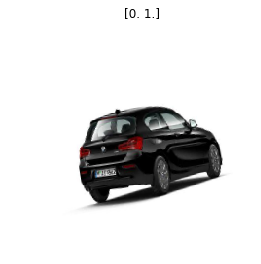

In [13]:
plt.figure()
plt.title(y_batch[0])
plt.axis('off')
plt.imshow(X_batch/255)

__Define Parameters__

In [31]:
batch_size = 32
epochs = 50
seed = 7
patience = 10
class_weight = {0 : 1., 
                1: 1.}
steps_per_epoch = np.ceil(3000 / batch_size)
validation_steps = np.ceil(862 / batch_size)
early_stop_criteria = 'val_acc' # Why not Validation Loss?
checkpoint_criteria = 'val_acc'
optimizer = 'adadelta'
loss = 'binary_crossentropy'
number_classes = 2
input_shape= (224,224,3) # Standard for ResNet: (224,224,3)
verbose = 1
#general callbacks
stop = EarlyStopping(monitor=early_stop_criteria, patience=patience, verbose=0, mode='auto')
weights_path='checkpoint_weights/'
checkpoint = ModelCheckpoint(weights_path+'weights.{epoch:02d}-{val_loss:.2f}'+'.hdf5', monitor=checkpoint_criteria, save_best_only=True, mode='auto')
metrics=['accuracy']

__Transferlearning with ResNet50__

In [32]:
def load_model(input_shape, number_classes, ret_len=False):
    # pop the global average pooling layer
    model = ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling='max', classes=number_classes)
    model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') # cant include weights anymore? - should be possible
    n_bb = len(model.layers)-3
    x = model.layers[-3].output
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    pred = Dense(number_classes,activation='softmax')(x)
    model = Model(input=model.input, output=pred)
    n_top = len(model.layers) - n_bb
    print('model loaded')
    return (model, n_top) if ret_len else model

In [33]:
print('loading model')
model,n_top = load_model(input_shape,number_classes,ret_len=True)

loading model
model loaded


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__Stagewise Training__

In [35]:
def freeze_to(model, top_n):
    """Set the top n layers of model to trainable"""
    
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[0:(len(model.layers)-top_n)]:
        layer.trainable = False

In [36]:
def unfreeze(model):
    """Set all layers of model to trainable"""
    
    for layer in model.layers:
        layer.trainable = True

In [37]:
def fit_strategy(model, strategy, fitgen_kwargs, loss=None, optimizer=None, metrics=None, verbose=False):
    """Fit a training strategy for model.
    
    model: The model to be trained
    stragegy: List of dicts with keys n_top (top trainable layers) and optionally loss, optimizer and/or metrics
    fitgen_kwargs: dict of keyword arguments to be passed to model.fit_generator
    """
    
    training_histories=[]
    
    for i, strat in enumerate(strategy):
        for k in ['loss', 'optimizer', 'metrics']:
            if k not in strat.keys():
                strat[k] = eval(k)
        if strat['n_top']:
            freeze_to(model, strat['n_top'])
        else:
            unfreeze(model)
        if verbose:
            print('Fit model with strategy no. {}:\n n_top: {};loss: {};optimizer:\n {};metrics: {};\n fitgen_kwargs: {}'.format(i, strat['n_top'], strat['loss'], strat['optimizer'], strat['metrics'], fitgen_kwargs))
        
        #check whether this is the first training
        if i == 0:
            model.compile(loss=strat['loss'], optimizer=strat['optimizer'], metrics=strat['metrics'])
        else:
            print('loading best model')
            list_of_checkpoints = glob.glob(weights_path+'*') # * means all if need specific format then *.csv
            best_checkpoint = max(list_of_checkpoints, key=os.path.getctime)
            model.load_weights(best_checkpoint)
        training_history = model.fit_generator(**fitgen_kwargs)
        training_histories.append(training_history)
    list_of_checkpoints = glob.glob(weights_path+'*') # * means all if need specific format then *.csv
    best_checkpoint = max(list_of_checkpoints, key=os.path.getctime)
    model.load_weights(best_checkpoint)
    return model, training_histories
        
        # fits the model on batches with real-time data augmentation:


__Define Strategy__

In [38]:
strategy = [{'n_top': n_top}, {'n_top': None}]
fitgen_kwargs = {
    'generator': train_datagen.flow(X_train, Y_train, batch_size=batch_size), 
    'steps_per_epoch': steps_per_epoch, 
    'epochs': epochs,
    'callbacks': [checkpoint,stop], 
    'validation_data': validation_datagen.flow(X_validation, Y_validation, batch_size=batch_size),
    'class_weight': class_weight, 
    'verbose': verbose, 
    'validation_steps':validation_steps
}


__start training__

In [39]:
model, histories = fit_strategy(model, strategy, fitgen_kwargs, loss=loss, optimizer=optimizer, metrics=metrics, verbose=True)

Fit model with strategy no. 0:
 n_top: 9;loss: binary_crossentropy;optimizer:
 adadelta;metrics: ['accuracy'];
 fitgen_kwargs: {'validation_data': <keras.preprocessing.image.NumpyArrayIterator object at 0x7f94d92b9978>, 'generator': <keras.preprocessing.image.NumpyArrayIterator object at 0x7f94d92b9710>, 'verbose': 1, 'steps_per_epoch': 94.0, 'epochs': 50, 'validation_steps': 27.0, 'class_weight': {0: 1.0, 1: 1.0}, 'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7f957a79c7b8>, <keras.callbacks.EarlyStopping object at 0x7f957a79c400>]}
Epoch 1/50
94/94 [==============================] - 30s 318ms/step - loss: 0.8207 - acc: 0.6868 - val_loss: 0.6307 - val_acc: 0.7575
Epoch 2/50
94/94 [==============================] - 26s 274ms/step - loss: 0.5474 - acc: 0.7613 - val_loss: 0.5962 - val_acc: 0.7355
Epoch 3/50
94/94 [==============================] - 27s 288ms/step - loss: 0.4571 - acc: 0.7969 - val_loss: 0.5751 - val_acc: 0.7506
Epoch 4/50
94/94 [==============================]

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50
94/94 [==============================] - 28s 302ms/step - loss: 0.2559 - acc: 0.8946 - val_loss: 0.6000 - val_acc: 0.7807
Epoch 2/50
94/94 [==============================] - 27s 288ms/step - loss: 0.2345 - acc: 0.8999 - val_loss: 0.4216 - val_acc: 0.8295
Epoch 3/50
94/94 [==============================] - 28s 297ms/step - loss: 0.2409 - acc: 0.9039 - val_loss: 0.3704 - val_acc: 0.8654
Epoch 4/50
94/94 [==============================] - 27s 288ms/step - loss: 0.2199 - acc: 0.9092 - val_loss: 0.7810 - val_acc: 0.7529
Epoch 5/50
94/94 [==============================] - 27s 291ms/step - loss: 0.2401 - acc: 0.9086 - val_loss: 0.4540 - val_acc: 0.8329
Epoch 6/50
94/94 [==============================] - 27s 288ms/step - loss: 0.2257 - acc: 0.9053 - val_loss: 0.7949 - val_acc: 0.7425
Epoch 7/50
94/94 [==============================] - 27s 289ms/step - loss: 0.2107 - acc: 0.9152 - val_loss: 0.7600 - val_acc: 0.7448
Epoch 8/50
94/94 [==============================] - 27s 285ms/step - 

__Evaluate Training__

In [40]:
# list all data in history
for hist in histories:
    print(hist.history.keys())

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])
dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


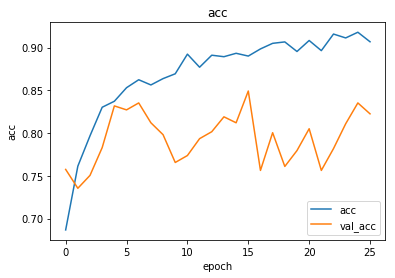

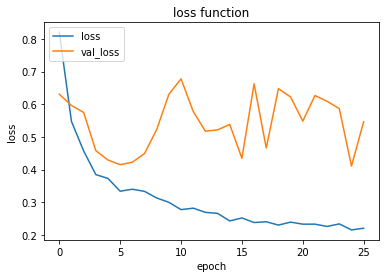

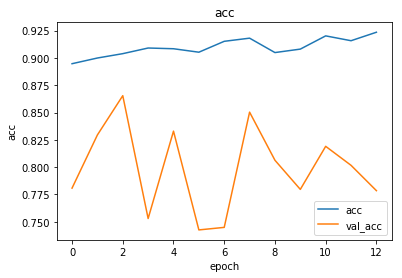

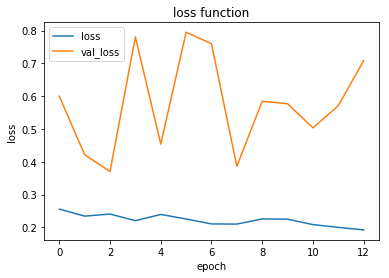

In [41]:
for hist in histories:
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc','val_acc'], loc='lower right')
    plt.show()

    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss function')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([ 'loss','val_loss'], loc='upper left')
    plt.show()

__Evaluate Model__

In [42]:
score = model.evaluate(X_test, Y_test, batch_size=32)

1000/1000 [==============================] - 2s 2ms/step


In [43]:
print(score)

[0.3214365330338478, 0.886]


## TODO: Result Visualization

In [62]:
X_batch, y_batch = X_test[1],Y_test[1]

In [63]:
X_batch = X_batch.reshape((224,224,3))

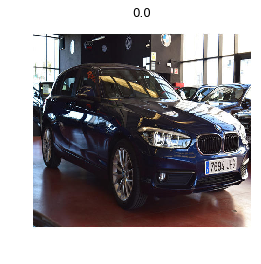

In [64]:
plt.figure()
plt.title(y_batch[0])
plt.axis('off')
plt.imshow(X_batch/255)

In [65]:
X_batch = X_batch.reshape((1,224,224,3))

In [66]:
X_batch.shape

(1, 224, 224, 3)

In [71]:
score = model.evaluate(X_batch, y_batch, batch_size=1)

ValueError: Error when checking target: expected dense_6 to have shape (2,) but got array with shape (1,)

In [70]:
y_batch.shape

(2,)

In [55]:
score

[0.05549982190132141, 1.0]